# Pytorch Workflow Fundamentals


Here,we are going to cover
1) Getting data ready	Data can be almost anything but to get started we're going to create a simple straight line
2. Building a model	Here we'll create a model to learn patterns in the data, we'll also choose a loss function, optimizer and build a training loop.
3. Fitting the model to data (training)	We've got data and a model, now let's let the model (try to) find patterns in the (training) data.
4. Making predictions and evaluating a model (inference)	Our model's found patterns in the data, let's compare its findings to the actual (testing) data.
5. Saving and loading a model	You may want to use your model elsewhere, or come back to it later, here we'll cover that.
6. Putting it all together

In [2]:
import torch
import matplotlib.pyplot as plt
from torch import nn

In [3]:
# checking pytorch version
torch.__version__

'2.4.1+cu124'

# 1)  Data (preparing and loading)
Here, we will use linear regression with known parameters.then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

In [4]:
#Creatinf known parameters(w and b)
weight = 0.7
bias = 0.3

#create data
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)# adds one dimension to 1st dimension
y = weight * X + bias
# let's see what X and y look like
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Spliting data into training and test sets

In [5]:
train_split = int(0.8* len(X)) # requires and int for slicing
X_train,y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]
len(X_train),len(y_train),len(X_test),len(y_test)


(40, 40, 10, 10)

Lets try to visualize the relationship between X_train and y_train

In [6]:
# lets create a function to visualize 
def plot_prediction(train_data=X_train,
                    train_label=y_train,
                    test_data = X_test,
                    test_label = y_test,predictions =None ):
    plt.figure(figsize=(10,7))
    #for training data
    plt.scatter(train_data,train_label, c="black",s=10,label="Training Data")
    #for test data
    plt.scatter(test_data,test_label, c="red",s=10,label="Testing Data")
    if predictions is not None:
        plt.scatter(test_data,predictions,c='blue',s=10,label="Prediction")
    plt.show()
   

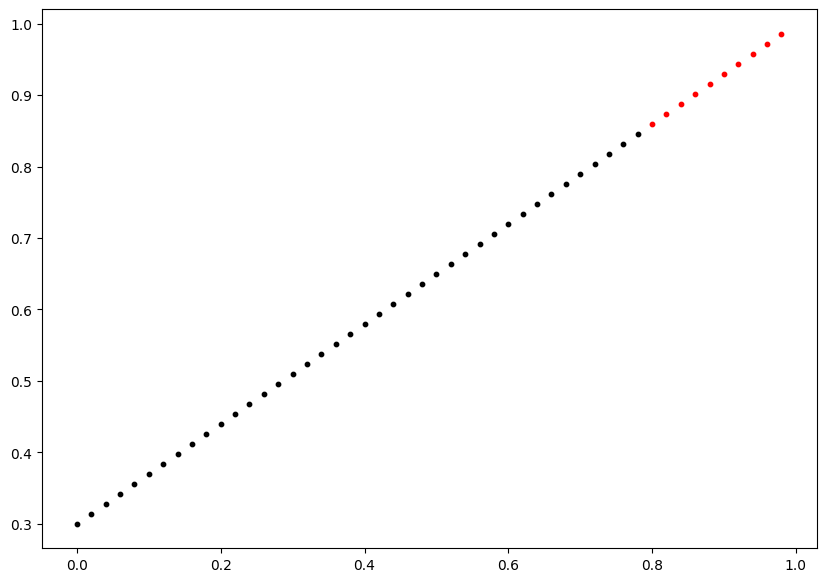

In [7]:
plot_prediction()

## 2) Build Model
Now, we will be using black dots to predict red dots

In [8]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # creates a random tensor for weight to start out with 
        self.weight = nn.Parameter(torch.randn(1,dtype=torch.float,requires_grad=True))

        self.bias = nn.Parameter(torch.randn(1,dtype=torch.float,requires_grad=True))
    def forward(self,x: torch.Tensor)-> torch.Tensor:
        return self.weight * x + self.bias

Explantion: Here we have a class LinearRegressionModel which inherits from a base class nn.module(contains building blocks for neural network). we also use a special class nn.Paramters in pytorch that is used to indicate that a particular tensor is learnable.When a tensor is wrapped in nn.Parameter, it is automatically added to the model's parameters. This means that when you call model.parameters() in PyTorch, it will include this parameter in the returned iterable. You can learn about it in it's official documentation

### Checking the contents of Pytorch model


In [9]:
# set manuail seed as nn.Parameters are randomly initialized
torch.manual_seed(42)

#lets create a instance of the model class
model = LinearRegressionModel()

#check the nn.Parameters 
list(model.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
#list named parameters
model.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions through torch.inference_mode()


In [11]:
# make predictions with model
with torch.inference_mode():
    y_preds = model(X_test)

In [12]:
# checking the predictions
print(f"NUmber of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values: {y_preds}")

NUmber of testing samples: 10
Number of predictions made: 10
Predicted values: tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


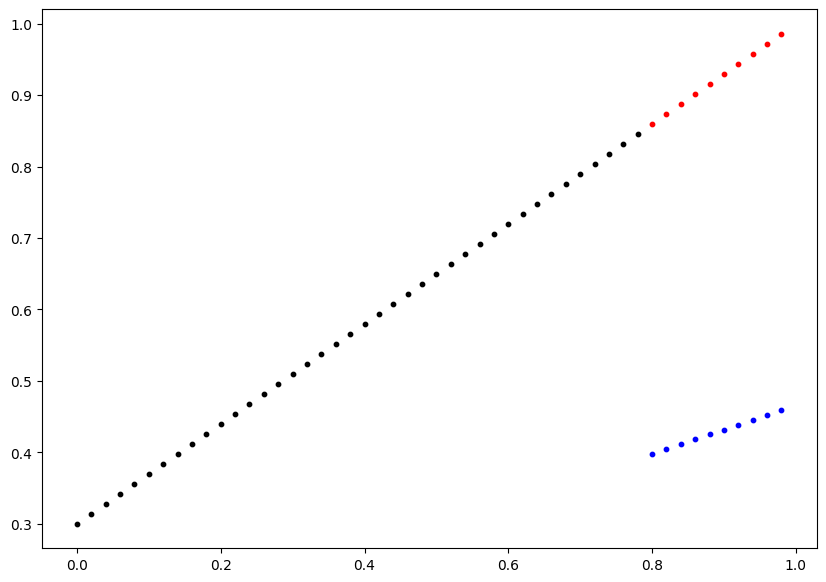

In [13]:
plot_prediction(predictions=y_preds)

As we can see the prediction is way out. we can further check that by subtracting the original label and predicitons

In [14]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

### Train Model
We can now update it's internal parameters , the weights and bias values we set randomly using nn.Parameter() and torch.randn().To properly represent the data we can optimize it's loss fucntion

Loss Function is nothing but a fucntion that measures how off you are with your predictions and our job is to optimize it to have the least error

Let's create a loss function and a optimizer we can help improve our model.We use Mean absolute error and for optimizer we use Stochastic gradient descent

In [15]:
loss_fn = nn.L1Loss() # MAE loss is same as L1loss

#create an optimizer
optimizer = torch.optim.SGD(params =model.parameters(),lr =0.01)# lr is the learning rate



Now lets create a optimization loop in Pytorch
1) Forward pass - The model goes through all of the training data once, performing its forward() function calculations. 

2) Calculate the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.

3) Zero Gradients - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.

4) Perform Backpropagation - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards

5) Update the optimizer(Gradient Descent) - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them.


In [16]:
torch.manual_seed(42)

epochs = 100 # how many times the model will updates it's parameters

train_loss_values = [] # empty list to track values
test_loss_values = []
epochs_count = []

for epoch in range(epochs):
    model.train() # this is the default state of model
    # forward pass on train data using forward() method
    y_preds = model(X_train)
    # print(y_preds)

    # calculating the loss
    loss = loss_fn(y_preds,y_train)

    #zero grad of the optimizer
    optimizer.zero_grad()

    # loss backwards
    loss.backward()

    #progress the optimizer
    optimizer.step()

    ####-------Testing--------
    #put the model is evaluation
    model.eval()

    with torch.inference_mode():
        # forward pass ont test data
        test_preds = model(X_test)
        # print(test_preds)

        # calculating the loss on test data
        test_loss = loss_fn(test_preds,y_test.type(torch.float))

        # printing out what's happening
        if epochs % 10 == 0 :
            epochs_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss : {loss} | MAE Test loss : {test_loss}")



Epoch: 0 | MAE Train Loss : 0.31288138031959534 | MAE Test loss : 0.48106518387794495
Epoch: 1 | MAE Train Loss : 0.3013603389263153 | MAE Test loss : 0.4675942063331604
Epoch: 2 | MAE Train Loss : 0.28983935713768005 | MAE Test loss : 0.4541231691837311
Epoch: 3 | MAE Train Loss : 0.2783183455467224 | MAE Test loss : 0.44065219163894653
Epoch: 4 | MAE Train Loss : 0.26679736375808716 | MAE Test loss : 0.4271811842918396
Epoch: 5 | MAE Train Loss : 0.2552763521671295 | MAE Test loss : 0.41371020674705505
Epoch: 6 | MAE Train Loss : 0.24375534057617188 | MAE Test loss : 0.40023916959762573
Epoch: 7 | MAE Train Loss : 0.23223432898521423 | MAE Test loss : 0.3867681920528412
Epoch: 8 | MAE Train Loss : 0.22071333229541779 | MAE Test loss : 0.37329721450805664
Epoch: 9 | MAE Train Loss : 0.20919232070446014 | MAE Test loss : 0.3598262071609497
Epoch: 10 | MAE Train Loss : 0.1976713240146637 | MAE Test loss : 0.3463551998138428
Epoch: 11 | MAE Train Loss : 0.18615034222602844 | MAE Test los

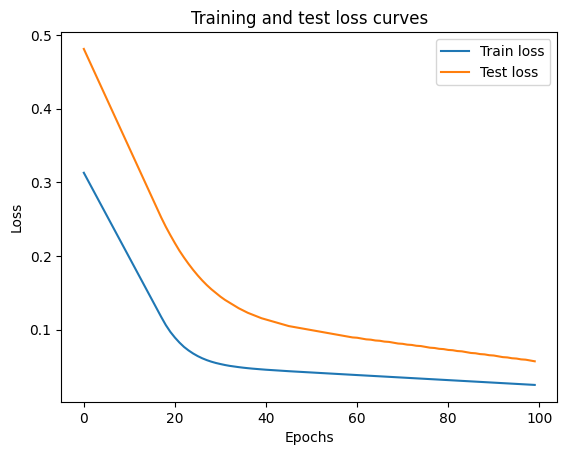

In [17]:
# Plot the loss curves
plt.plot(epochs_count, train_loss_values, label="Train loss")
plt.plot(epochs_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

From the plot above you can see that the loss is decreasing with each epoch.Now lets see how the model predicted vs the original year

In [18]:
print(f"The original value of weight is {weight} and for bias is {bias}")
print(f"The predicted values is {model.state_dict()}")

The original value of weight is 0.7 and for bias is 0.3
The predicted values is OrderedDict({'weight': tensor([0.5784]), 'bias': tensor([0.3513])})


We can see that we somehow came close to the original values we set up


### Making predictions with a trained Pytorch model(Inference)


There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

1) Set the model in evaluation mode (model.eval()).
2) Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).
3) All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

In [19]:
model.eval()# setting model in evaluation mode
with torch.inference_mode():
    y_preds = model(X_test)

y_preds


tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

Now lets plot the prediction vs training data and testing data


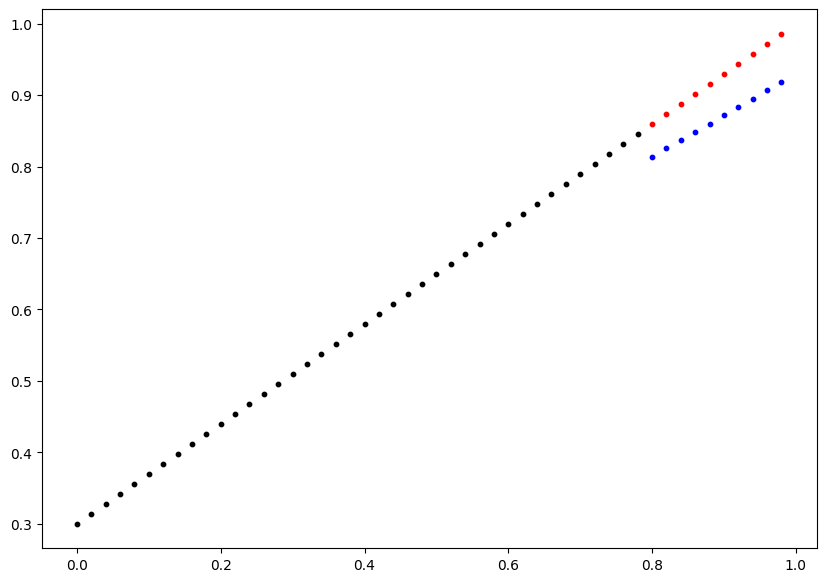

In [20]:
plot_prediction(predictions=y_preds)

As we can see the predicted values are very close to ur original values

## Saving and loading a Pytorch model
There are three main methods to save your model
1) torch.save
2) torch.load
3) torch.nn.Module.load_state_dict

#### Saving a Pytorch model's state_dict()
The recommended way for saving and loading a model for inference is by saving and loading a model's state_dict()
 
Here are the steps,
1) Create a directory for saving models to called models using Pythons's pathlib module
2) Create a file path to save the model to.
3) We'll call torch.save(obj, f) where obj is the target model's state_dict() and f is the filename of where to save the model.


In [21]:
from pathlib import Path

# creating a directory for saving model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

#creat model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

#Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth


### Loading a saved Pytorch model's state_dict()

Since we have already saved model state_dict(), we can now load it using torch.nn.Module.load_state_dict(torch.load(f)) where f is the filepath of our saved model state_dict().
Note: We have only saved the models state_dict() which is a dictionary of learned parameters and not the entire model  we first have to load the state_dict() with torch.load() and then pass that state_dict() to a new instance of our model (which is a subclass of nn.Module).

The disadvantage of  approach (saving the whole model) is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...

Because of this, your code can break in various ways when used in other projects or after refactors

In [22]:
# make a new instance of our model
loaded_model = LinearRegressionModel()

#load the model
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

C:\Users\Acer nitro\AppData\Local\Temp\ipykernel_3236\1610774410.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH)

<All keys matched successfully>

Now to test our loaded model,lets perform inference as before

In [23]:
loaded_model.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)

loaded_model_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

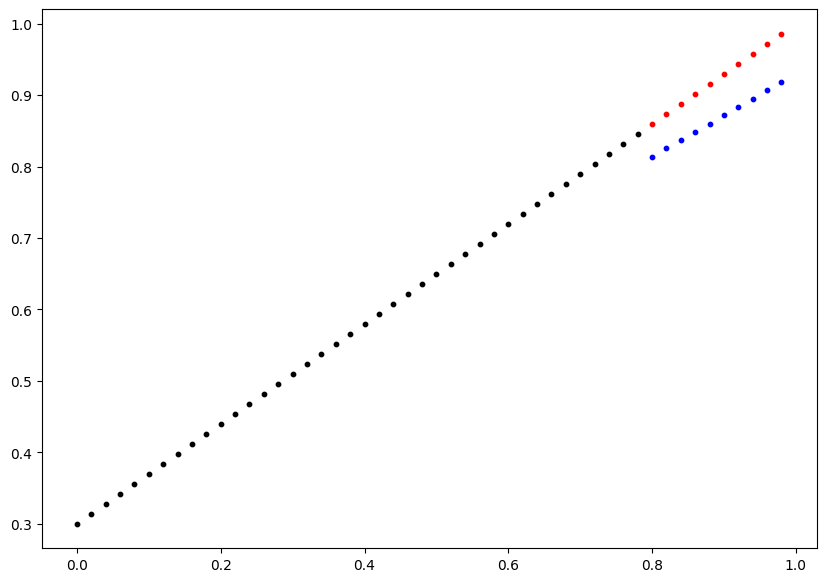

In [24]:
# lets plot it 
plot_prediction(predictions=loaded_model_preds)

Now, lets do all this in a GPU and wrap up what we have learned

In [25]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [26]:
# setting up the device
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

Lets create  some data just like before

In [27]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

#create X and y(features and label)
X = torch.arange(start=start,end=end,step=step).unsqueeze(dim=1)
y = X * weight + bias
X[:10] ,y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [28]:
# spliting the data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split],y[:train_split]

X_test, y_test = X[train_split:], y[train_split:]

len(X_train),len(X_test),len(y_train),len(y_test)

(40, 10, 40, 10)

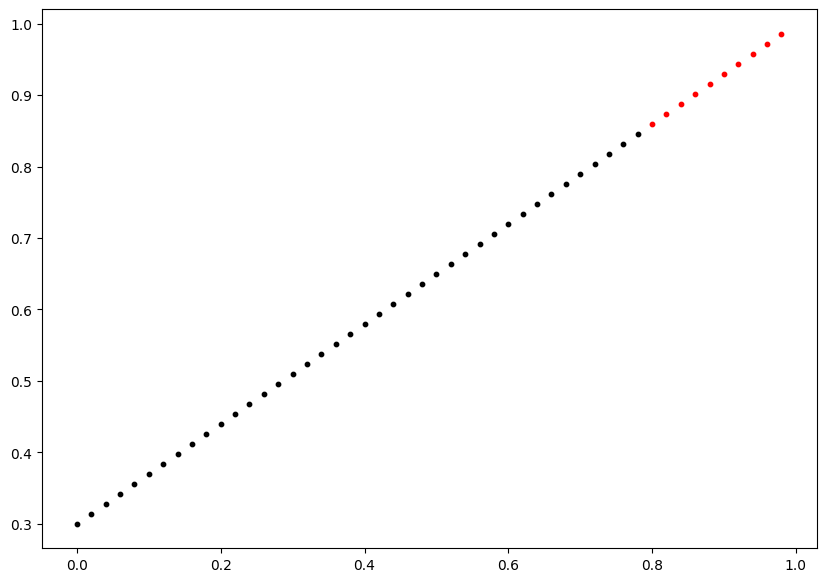

In [29]:
# lets visualize using our previous functions
plot_prediction(X_train, y_train, X_test, y_test)

Building the Pytorch Linear Model.We'll create the same style of model as before except this time, instead of defining the weight and bias parameters of our model manually using nn.Parameter(), we'll use nn.Linear(in_features, out_features) to do it for us.

In [30]:
class LinearRegressionModel1V2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,out_features=1)

    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
torch.manual_seed(42)
model_1 = LinearRegressionModel1V2()
model_1,model_1.state_dict()

(LinearRegressionModel1V2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [31]:
#check the model device
next(model_1.parameters()).device

device(type='cpu')

In [32]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### Training the model

In [33]:
#create a loss function and a optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.01)


The only different thing we'll be doing in this step compared to the previous training loop is putting the data on the target device.

We've already put our model on the target device using model_1.to(device).

And we can do the same with the data

In [39]:
torch.manual_seed(42)

epochs = 1000
X_test = X_test.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    # train mode
    model_1.train()

    #forward pass
    y_pred = model_1(X_train)

    #calculate loss
    loss = loss_fn(y_pred,y_train)

    # zero grad optimizer
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    #step the optimizer
    optimizer.step()

    ## testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)

        #calcultae the testing loss
        test_pred = loss_fn(test_pred,y_test)
    if epochs % 10 == 0:
        print(f"Epoch:{epoch} | Training Loss:{loss} | Test Loss:{test_loss} \n")
    


Epoch:0 | Training Loss:0.006215683650225401 | Test Loss:0.05687814950942993 

Epoch:1 | Training Loss:0.005878167692571878 | Test Loss:0.05687814950942993 

Epoch:2 | Training Loss:0.005529168527573347 | Test Loss:0.05687814950942993 

Epoch:3 | Training Loss:0.005190468858927488 | Test Loss:0.05687814950942993 

Epoch:4 | Training Loss:0.004843969829380512 | Test Loss:0.05687814950942993 

Epoch:5 | Training Loss:0.004501462914049625 | Test Loss:0.05687814950942993 

Epoch:6 | Training Loss:0.004158765077590942 | Test Loss:0.05687814950942993 

Epoch:7 | Training Loss:0.00381244788877666 | Test Loss:0.05687814950942993 

Epoch:8 | Training Loss:0.003473566612228751 | Test Loss:0.05687814950942993 

Epoch:9 | Training Loss:0.0031245655845850706 | Test Loss:0.05687814950942993 

Epoch:10 | Training Loss:0.00278724217787385 | Test Loss:0.05687814950942993 

Epoch:11 | Training Loss:0.0024393596686422825 | Test Loss:0.05687814950942993 

Epoch:12 | Training Loss:0.00209822878241539 | Tes

Let's check the parameters our model has learned and compare them to the original parameters we hard-coded

In [40]:
from pprint import pprint #preety print
print("The model has learned the following values for weight")
pprint(model_1.state_dict())
print("\n The Original values for weight and biases are: ")
print(f"Weight:{weight}, Bias: {bias}")

The model has learned the following values for weight
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

 The Original values for weight and biases are: 
Weight:0.7, Bias: 0.3


We have gotten some pretty close values

### Making predictions


In [41]:
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds,y_preds.device

(tensor([[0.8600],
         [0.8739],
         [0.8878],
         [0.9018],
         [0.9157],
         [0.9296],
         [0.9436],
         [0.9575],
         [0.9714],
         [0.9854]], device='cuda:0'),
 device(type='cuda', index=0))

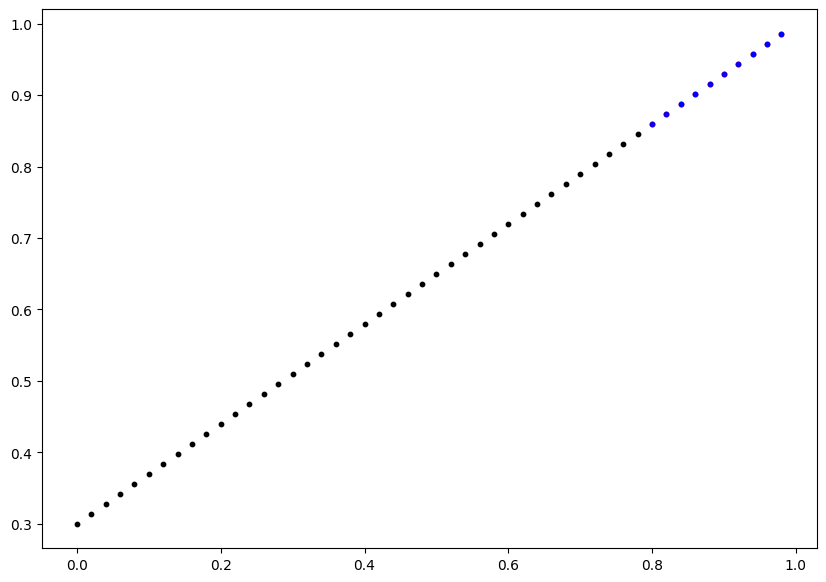

In [42]:
plot_prediction(predictions=y_preds.cpu())

The line perfectly aligns with black dots

### Saving the model

In [43]:
from pathlib import Path
#1) create model directory
MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#2) Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#3) Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)

Saving model to: Models\01_pytorch_workflow_model_1.pth


### Loading the saved model

In [50]:
loaded_model_1 = LinearRegressionModel1V2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

#putting the model to target device
loaded_model_1.to(device)

print(f"Loaded model: \n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model: 
LinearRegressionModel1V2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


C:\Users\Acer nitro\AppData\Local\Temp\ipykernel_3236\883648461.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH

In [52]:
# evaluate the loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)

loaded_model_1_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')